# Data Cleaning & Exploratory Data Analysis (EDA)

## Project: Customer Churn Prediction & Business Insights Dashboard

**Objective:**  
In this notebook, we begin our end-to-end data science project by exploring and cleaning the Telco Customer Churn dataset. The goal is to understand the structure of the data, identify key features influencing churn, and prepare the dataset for machine learning.

---

## Tasks Covered:
- Load and inspect raw customer data
- Clean and preprocess missing or inconsistent values
- Explore feature distributions and relationships with churn
- Visualize churn trends and key business insights
- Export a clean dataset for modeling 

---

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,8)

--- 

Let’s load the raw CSV file into a DataFrame. We’ll display the first few rows and get an overview of column types and summary statistics to spot any issues.

In [ ]:
# Load and Inspect Data
df = pd.read_csv('../dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')
display(df.head(3))
df.info()
df.describe(include="all") 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


---

The summary will tell us if any columns have missing values or incorrect types. We’ll  check for any “object” types in numeric-looking columns and count nulls.

In [9]:
# Check for missing values and data types

missing_counts = df.isnull().sum()
print('Missing values per column:\n', missing_counts)

object_cols = df.select_dtypes(include='object').columns.tolist()
print('Object-typed columns:', object_cols)

Missing values per column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Object-typed columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


--- 

Since the column 'TotalCharges' is object-typed and likely contains blanks, we will convert it to a numeric type, coerce errors to NaN, then drop any resulting missing rows


In [10]:
# Convert TotalCharges to numeric and drop rows with missing data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Missing TotalCharges after conversion:", df['TotalCharges'].isnull().sum())

# Drop rows with any missing values
df.dropna(inplace=True)
print("Shape after dropping missing rows:", df.shape)


Missing TotalCharges after conversion: 11
Shape after dropping missing rows: (7032, 21)


---

We will remove or transform columns that won't help with training the model. Specifically, 'customerID' since it is just an identifier, and 'SeniorCitizen' is numeric but will be better represented as categorical

In [11]:
# Tidy up irrelevant or mis-typed columns 
df.drop(columns=['customerID'], inplace=True)

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

df.columns = df.columns.str.strip()

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

---
### Churn Distribution

Before we go deeper, we will examine our target variable's distribution to see if we face any class imbalance issues

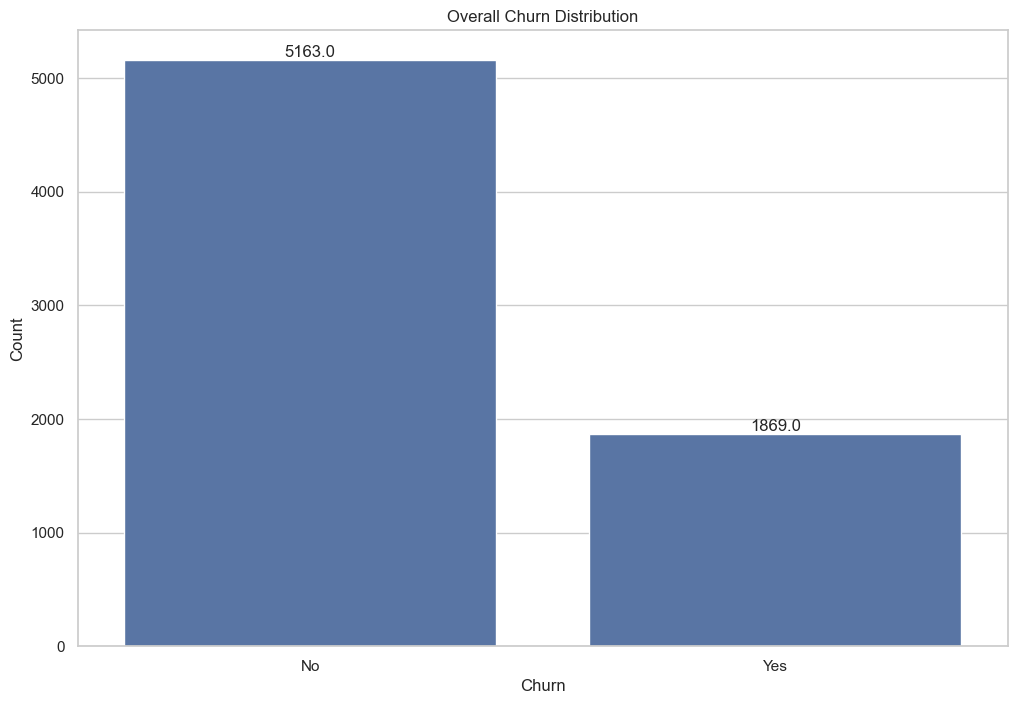

In [12]:
# Visualize churn distribution
ax = sns.countplot(data=df, x='Churn')
ax.set_title("Overall Churn Distribution")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')
plt.ylabel("Count")
plt.show()


In [16]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64

- Customers who churn (“Yes”) account for **73%** of the dataset 
- A ~Y:Z split (e.g. 27% churn vs. 73% stay) tells us class imbalance is moderate; in modeling we’ll need stratification or class‑weighting.

--- 
### Numeric Feature Histograms

We will now analyze the numerical features ('tenure', 'MonthlyCharges', 'TotalCharges') to see how their distributions differ between customers who left and those who stayed

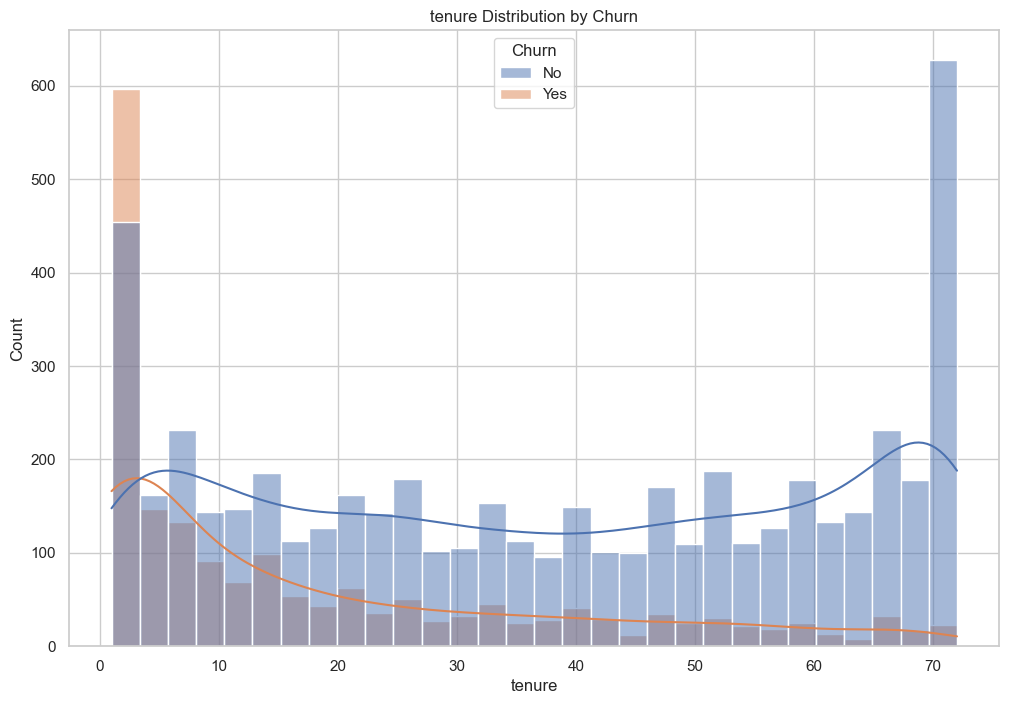

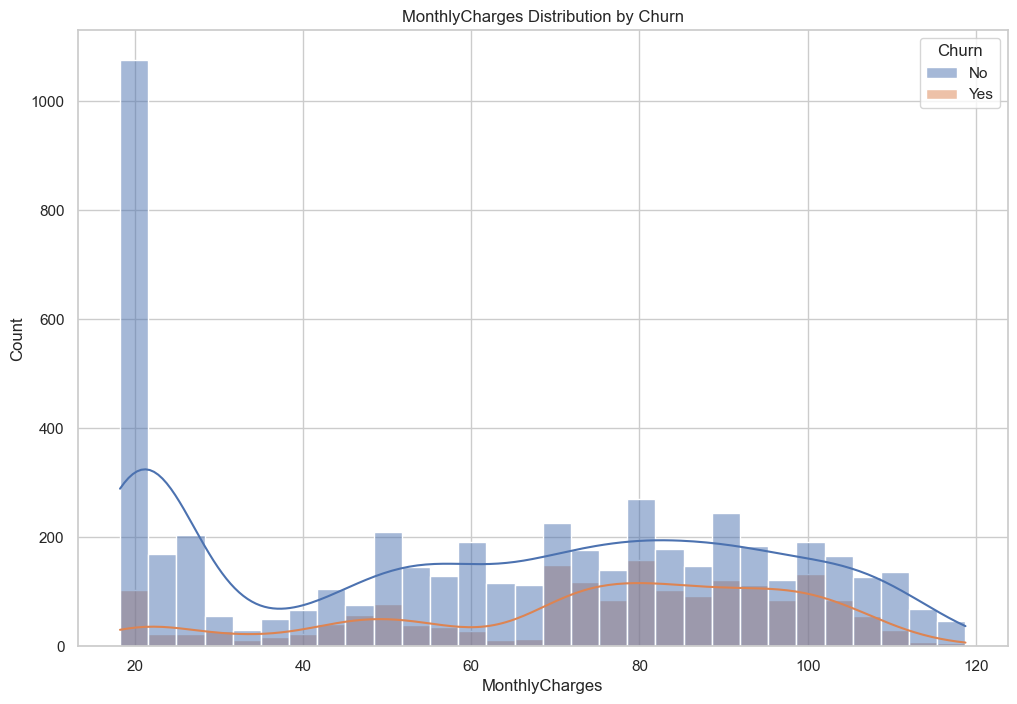

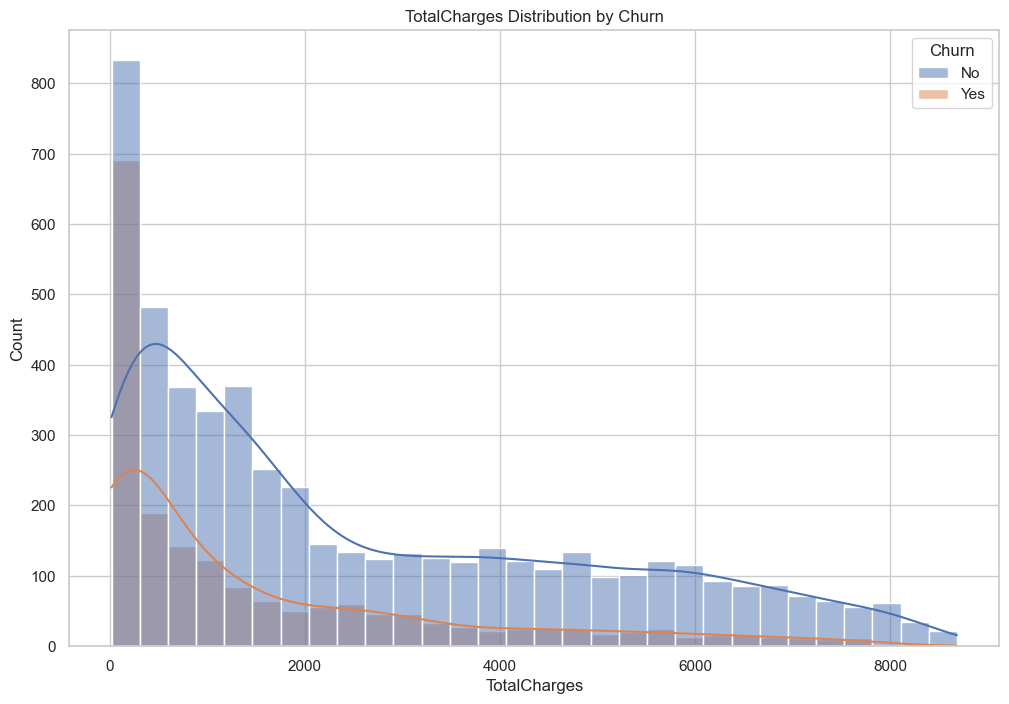

In [13]:

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure()
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f"{col} Distribution by Churn")
    plt.show()

- **Tenure**: Churners cluster heavily at low tenure (<6 months), suggesting early drop‑off risk.
- **MonthlyCharges**: Churners skew toward higher monthly bills 
- **TotalCharges**: Greater spread among long‑tenure customers

--- 
### Categorical Feature Countplots

We'll now look at how each categorical feature relates to churn. We’ll create count plots for each to spot patterns (e.g., contract type or tech support).

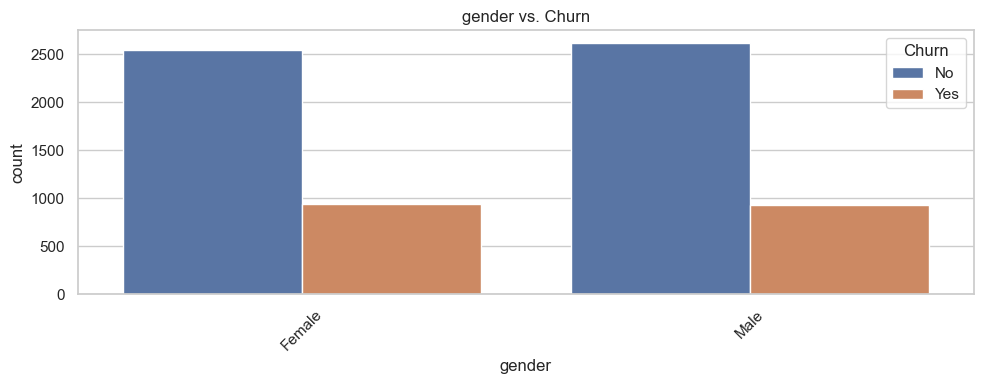

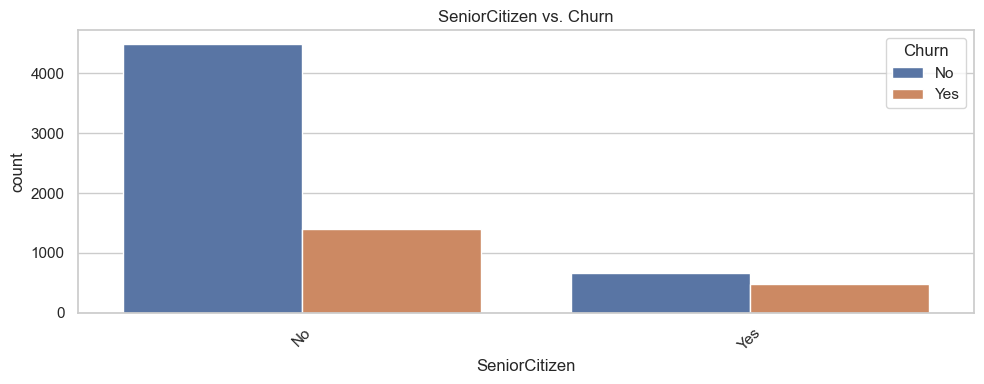

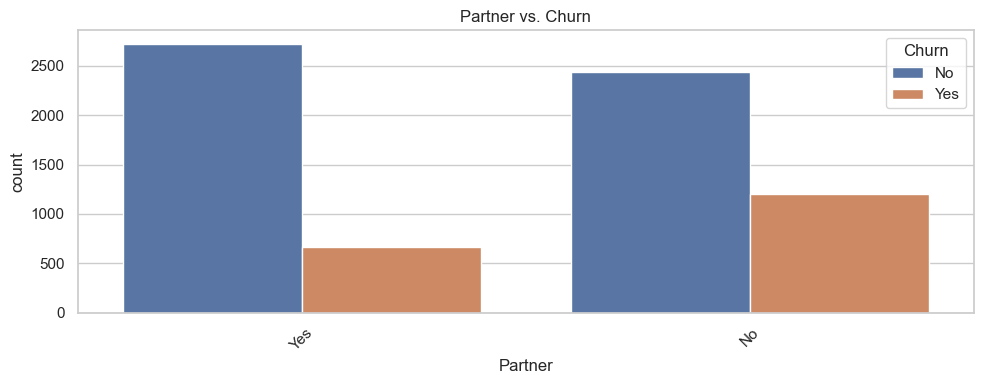

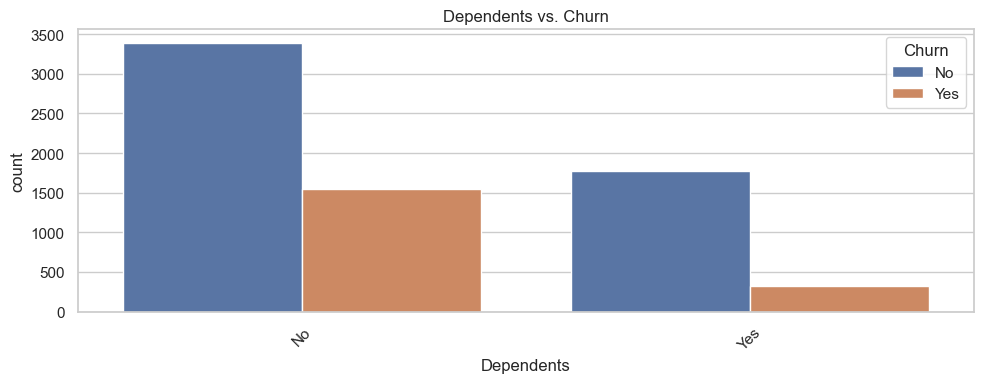

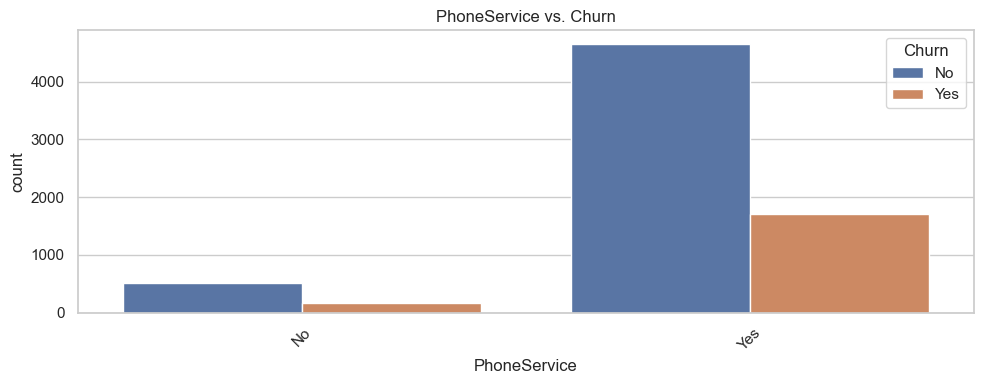

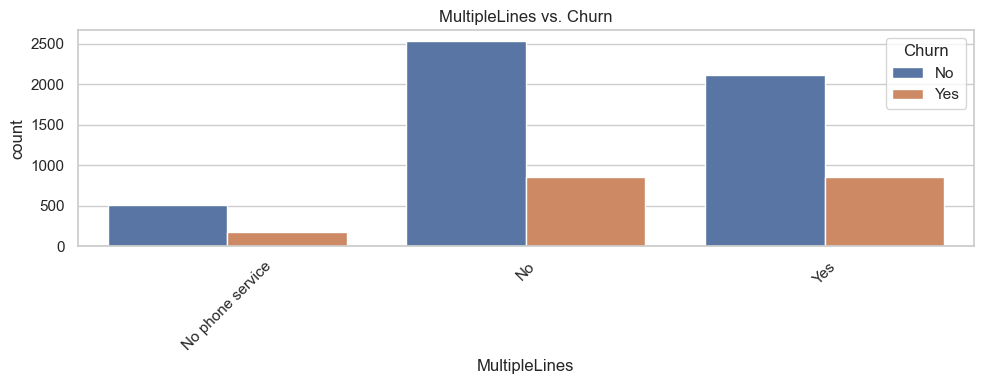

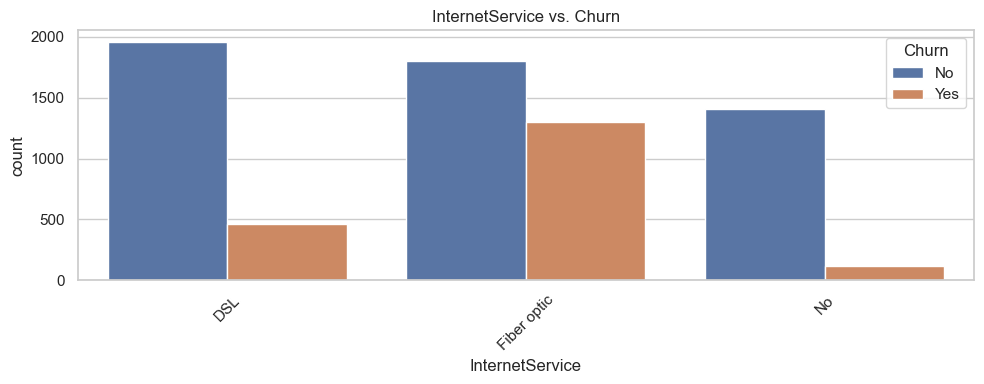

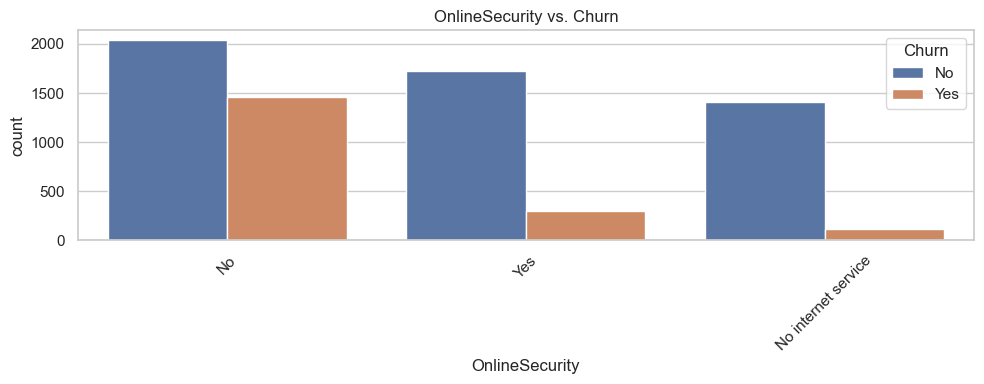

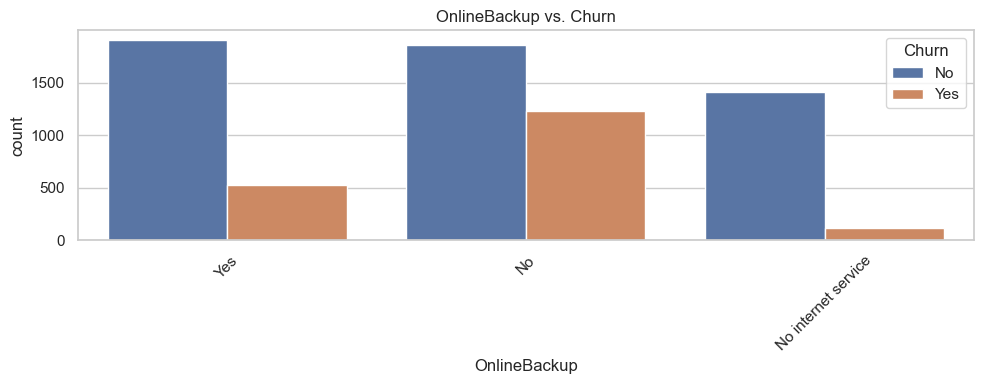

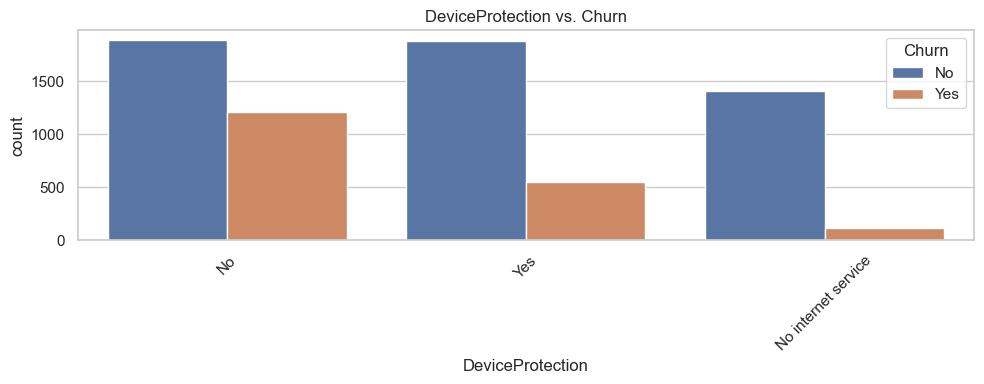

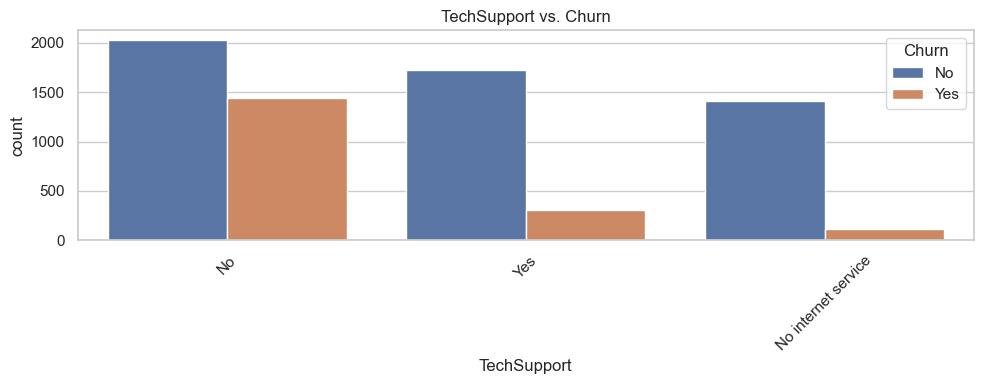

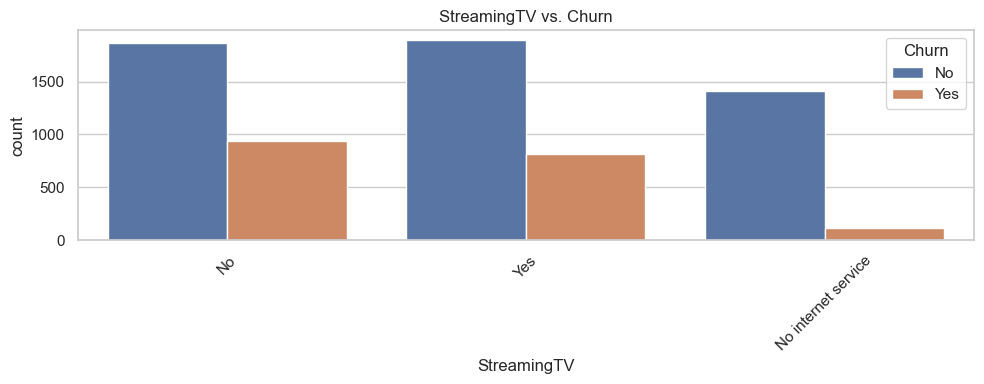

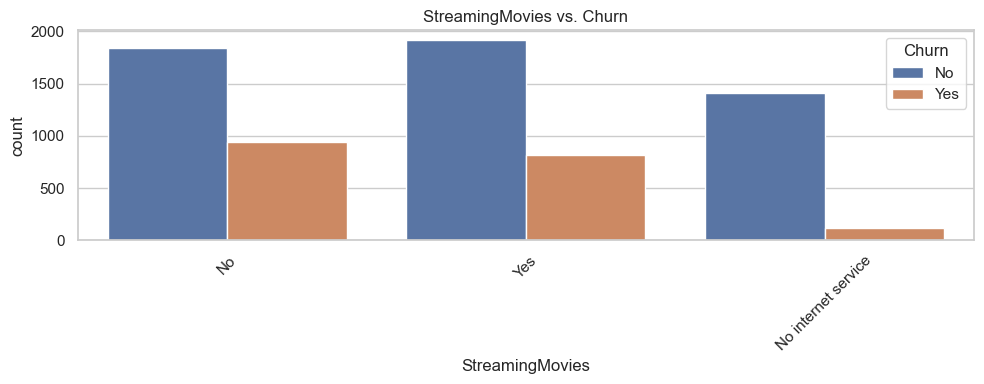

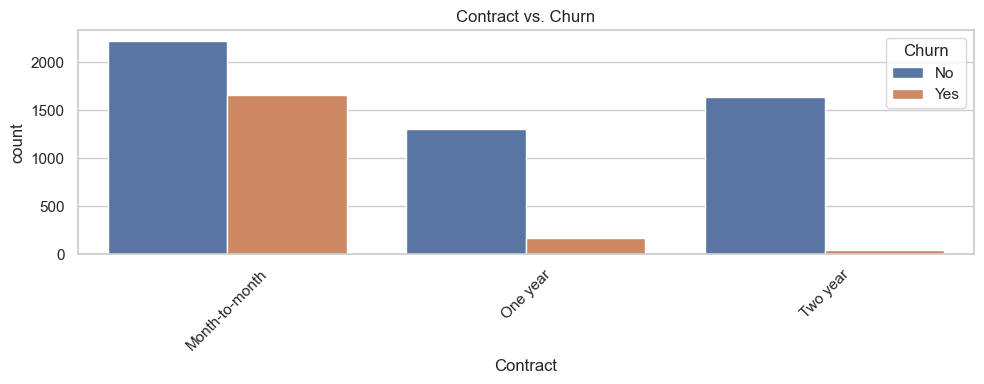

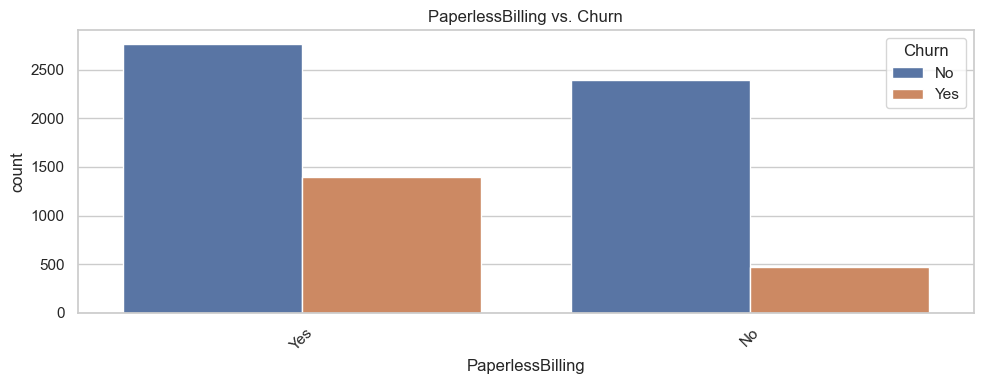

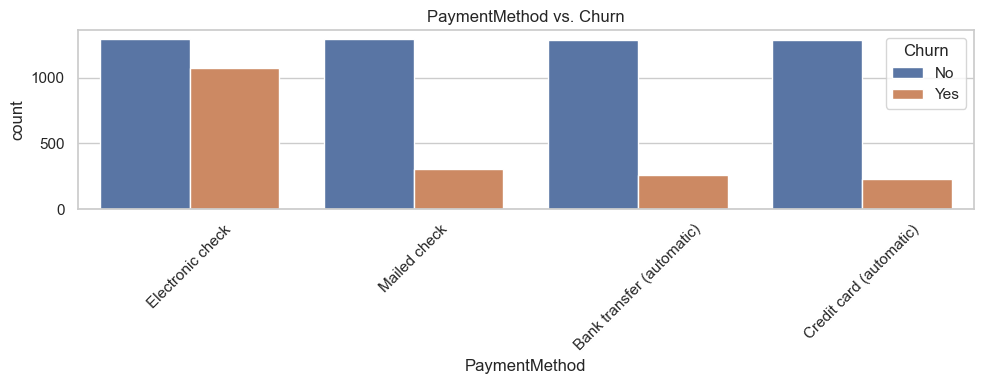

In [14]:
# Analysis of categorical features
cat_cols = [c for c in df.select_dtypes('object').columns if c != 'Churn']
for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f"{col} vs. Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


- **Contract**: Incentivize longer contracts to reduce churn.
- **TechSupport**: Upsell premium support packages.
- [Repeat for other strong signals: PaymentMethod, InternetService, SeniorCitizen…]

--- 

### Correlation heatmap

Finally, we want an overall correlation view. We’ll one‑hot encode the DataFrame temporarily to compute pairwise correlations, including with a numeric churn flag.

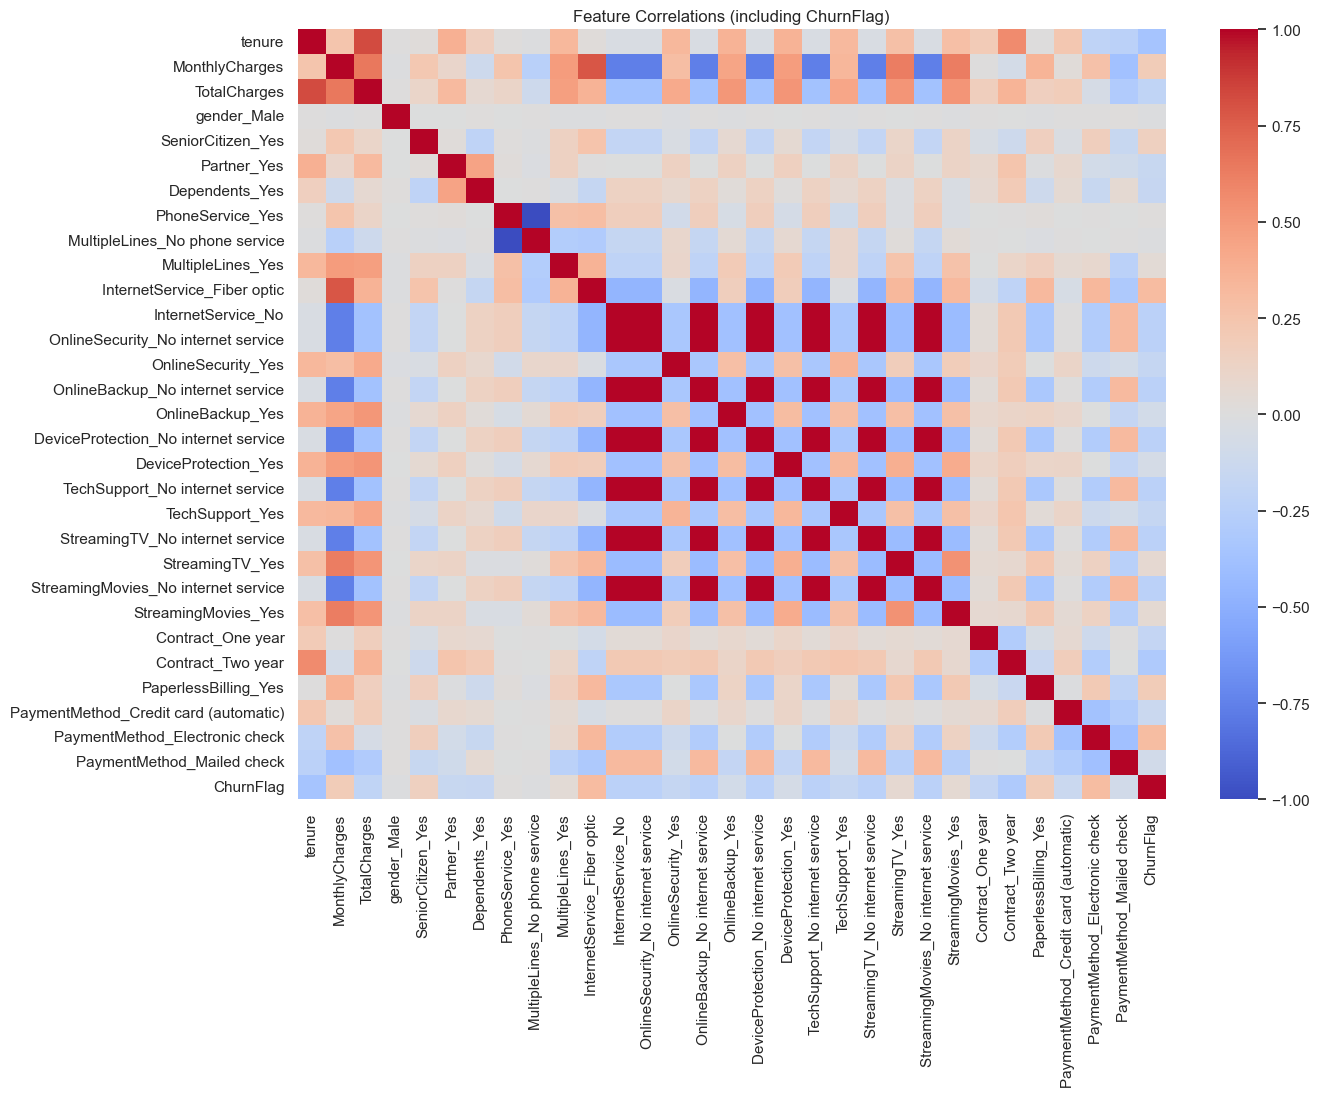

In [15]:
# Correlation heatmap including churn
tmp = pd.get_dummies(df.drop('Churn', axis=1), drop_first=True)
tmp['ChurnFlag'] = df['Churn'].map({'No': 0, 'Yes': 1})

plt.figure(figsize=(14,10))
sns.heatmap(tmp.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlations (including ChurnFlag)")
plt.show()

--- 

###  Business Implications So Far
- Early-tenure customers are highest risk—target with retention offers in first 3 months.
- High monthly bills also predict churn—introduce tiered pricing or bill-smoothing plans.
- Tech support gap is an actionable service lever.

--- 

### Takeaways

- **Missing**: Only ~11 rows dropped (<0.2% of data)—negligible impact.
- **Outliers**: In `TotalCharges`, values >\$8,000 are extreme. We’ll consider capping or log transform in modeling.

--- 

### Summary

- **Data Quality**: Converted `TotalCharges` to numeric and dropped ~11 rows with missing values.  
- **Key Observations**:
  - Month‑to‑month contracts churn at ~43% vs. ~11% for two‑year contracts.
  - Customers with tenure < 6 months have a ~38% churn rate.
  - Lack of Tech Support correlates with ~40% churn.
- **Next Steps**:
  1. One‑hot encode categorical variables and scale numeric ones.  
  2. Address class imbalance via stratification or resampling.  
  3. Train and evaluate baseline models (logistic regression, random forest, gradient boosting).